<h1 style="display: inline-block; margin-right: -30px;">手書き絵認識AIを構築してみよう</h1>
<img src="img/magician.png" style="display: inline-block; vertical-align: middle; width: 80px; height: auto;" />

このワークブックでは、`quickdraw-small` データセットを使用して、手書き絵を認識するAIモデルを構築します。  
データセットの分析から始め、学習済みモデルのロード、テストデータセットでの予測、そしてGradioを用いたインタラクティブなゲームの作成までを行います。

<hr style="border-top: 2px solid #71EB8B;">

## <span style="color:#E5004C"> データセットの準備と分析 <span>

まずは必要なライブラリをインポートし、データセットを準備します。  

In [1]:
from IPython.display import HTML #ディスプレイ表示に使用するものをインポート
from utils.quick_draw import QuickDrawModel # ユーティリティライブラリからQuickDrawModelをインポート

データセットをロードしたり、モデルを構築したりするために必要なクラスを定義します。  
今回使用する`quickdraw-small`は多様な手書き絵を含むデータセットで、AIモデルの訓練に広く使用されています。

In [2]:
# 手書き絵の認識モデル(AI)に関するクラスを定義
qd = QuickDrawModel()

### データセットの概要確認

では、MNISTデータセットの時と同じように、学習用データセットとテストデータセットの総数を確認してみましょう。  
これにより、データセットの大きさを把握できます。


In [3]:
# 学習用とテストデータの総数を確認
qd.show_dataset_num()

学習用データ　　　: 4500000個
テスト用データ　　: 250000個
ラベルのクラス数　: 345個


結果を見てみると、今回のデータセットは前回のMNISTと比べてデータ数、クラス数共にかなりの量になっていることがわかります

### 学習用データセットの分布確認

また同じように、学習用データセット内で各クラスがどのように分布しているかをグラフを使って視覚化してみましょう。  
各クラスが均等になっていることが理想的です。


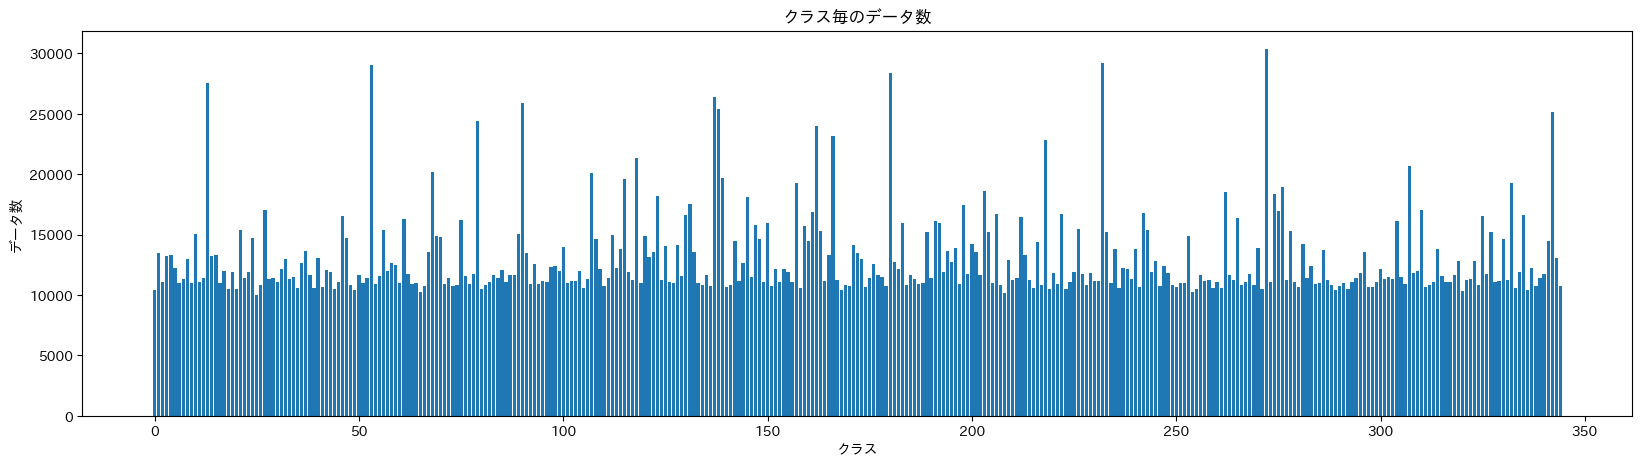

最少データ数のクラス: 【ラベル】 ベッド, 【総数】 10033
最大データ数のクラス: 【ラベル】 雪だるま, 【総数】 30365


In [4]:
# 学習用データセットの分布を確認
qd.show_dataset_graph()

こちらも結構ばらつきがありそうですが、一番少ないデータのクラスでも10000以上はあるので学習に大きな支障はなさそうです。

### テスト用データセットの分布確認

テスト用データセットのクラス分布を確認してみましょう。

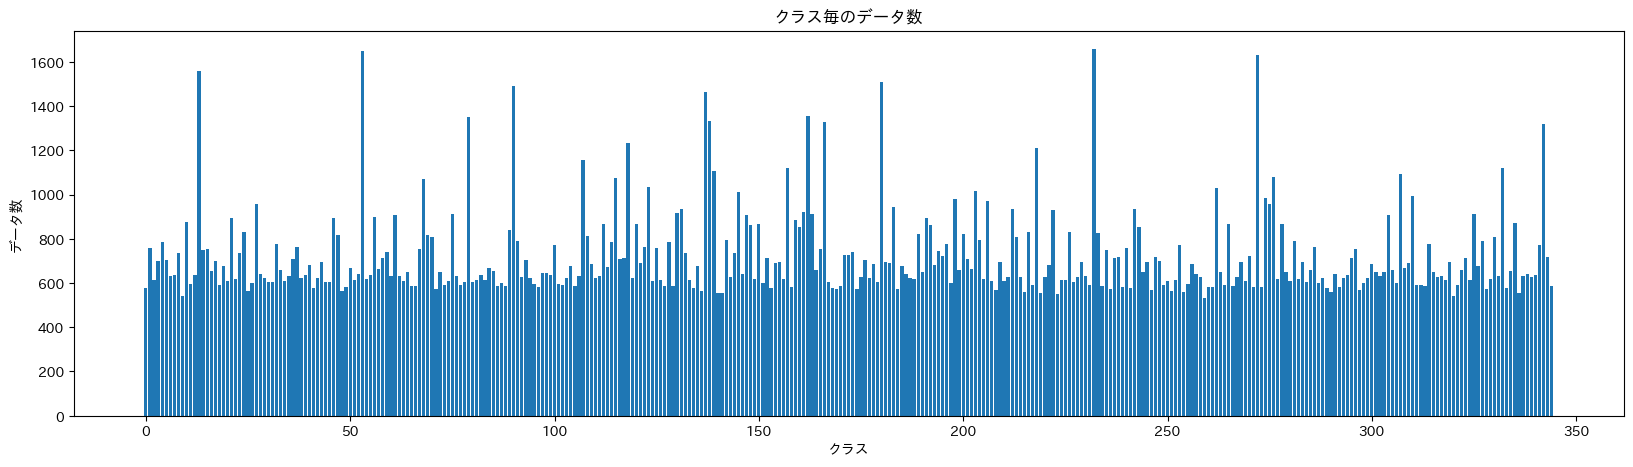

最少データ数のクラス: 【ラベル】 靴, 【総数】 532
最大データ数のクラス: 【ラベル】 ジャガイモ, 【総数】 1658


In [5]:
# テスト用データセットの分布を確認
qd.show_dataset_graph(dataset_type='test')

上の学習のデータセットのグラフと見比べてみても、テストデータで分布が変わったりはしていなさそうです。

## データセットの中身確認

次に、実際にデータセットの画像を表示してみましょう。  
ランダムに選ばれた画像を通じて、データセットに含まれる絵の種類を確認していきましょう。

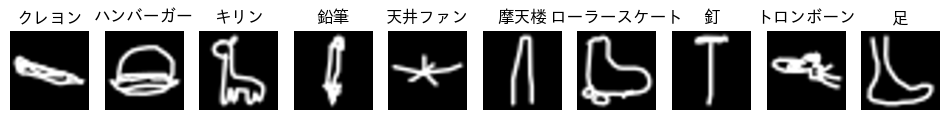

In [6]:
# データセットを確認
# 何回か実行してデータセットにどういった絵が存在するか確認してみてください。
qd.show_random_images_and_labels(10)

何回か実行してみて、どんなデータセットがあるのか確認してみてください。

### 特定のクラスのデータ確認

先ほど、学習のデータセットの分布を確認した時に出力した、  
最少データ数のクラス（例: ベッド）と最大データ数のクラス（例: 雪だるま）も確認してみましょう。  
データセット内の特定のクラスの画像を詳しく見て、絵のバリエーションも確認してみましょう。

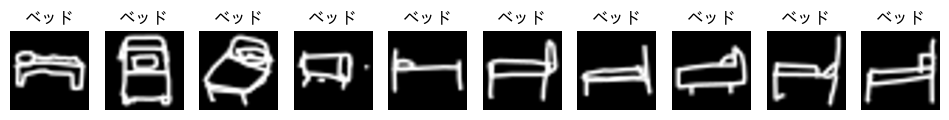

In [7]:
# データセットを確認
# 学習用データの最小データ数だった「ベッド」ラベルを確認
class_label = 'ベッド'
qd.show_random_images_and_labels(10, class_label=class_label)

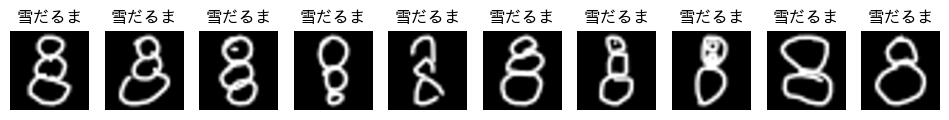

In [8]:
# データセットを確認
# 学習用データの最大データ数だった「雪だるま」ラベルを確認
class_label = '雪だるま'
qd.show_random_images_and_labels(10, class_label=class_label)

また、好きなデータのラベルを入れて、データを確認してみましょう。

<span style="color: blue; "> ★ </span> ***やってみよう！***  
`データセットの中身確認`で調べた絵の名前を`class_label`に入れて、どんな手書き絵があるか調べてみましょう。

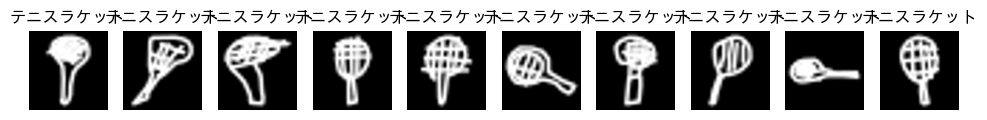

In [9]:
# データセットを確認
# 変数class_labelに好きなデータのラベルを入れて確認してみてください
class_label = ''
qd.show_random_images_and_labels(10, class_label=class_label)

<hr style="border-top: 2px solid #71EB8B;">

## <span style="color:#E5004C"> 学習済みモデルのロード </span>

今回のデータセットは大量のクラスを持つデータセットのため、学習には時間がかかります。  
そこで、今回は予め訓練済みのモデルをロードして使用することとします。

In [10]:
# 学習済みモデルをロード
path = "speed_sketch_dash/models/model.onnx"
model = qd.load_pretrained_model(path)

### 学習済みモデルの構造の表示

ロードが完了したら、学習済みモデルの構造を確認してみましょう。


In [11]:
# 学習済みモデルを表示
HTML(qd.plot_model())

MNISTで自分で用意したモデルより、かなり複雑になっていることがわかるかと思います。  
ですが、1つ1つの部品を見ていくと、MNISTで作ったlayerを組み合わせながら作っていっていることがわかります。

<hr style="border-top: 2px solid #71EB8B;">

## <span style="color:#E5004C"> AIの評価 </span>
### テストデータを使った予測
今回は、学習済みモデルを使ったので、学習過程の可視化は行いません。  
テストデータでの予測で、モデルの精度が問題ないか確認してみましょう。

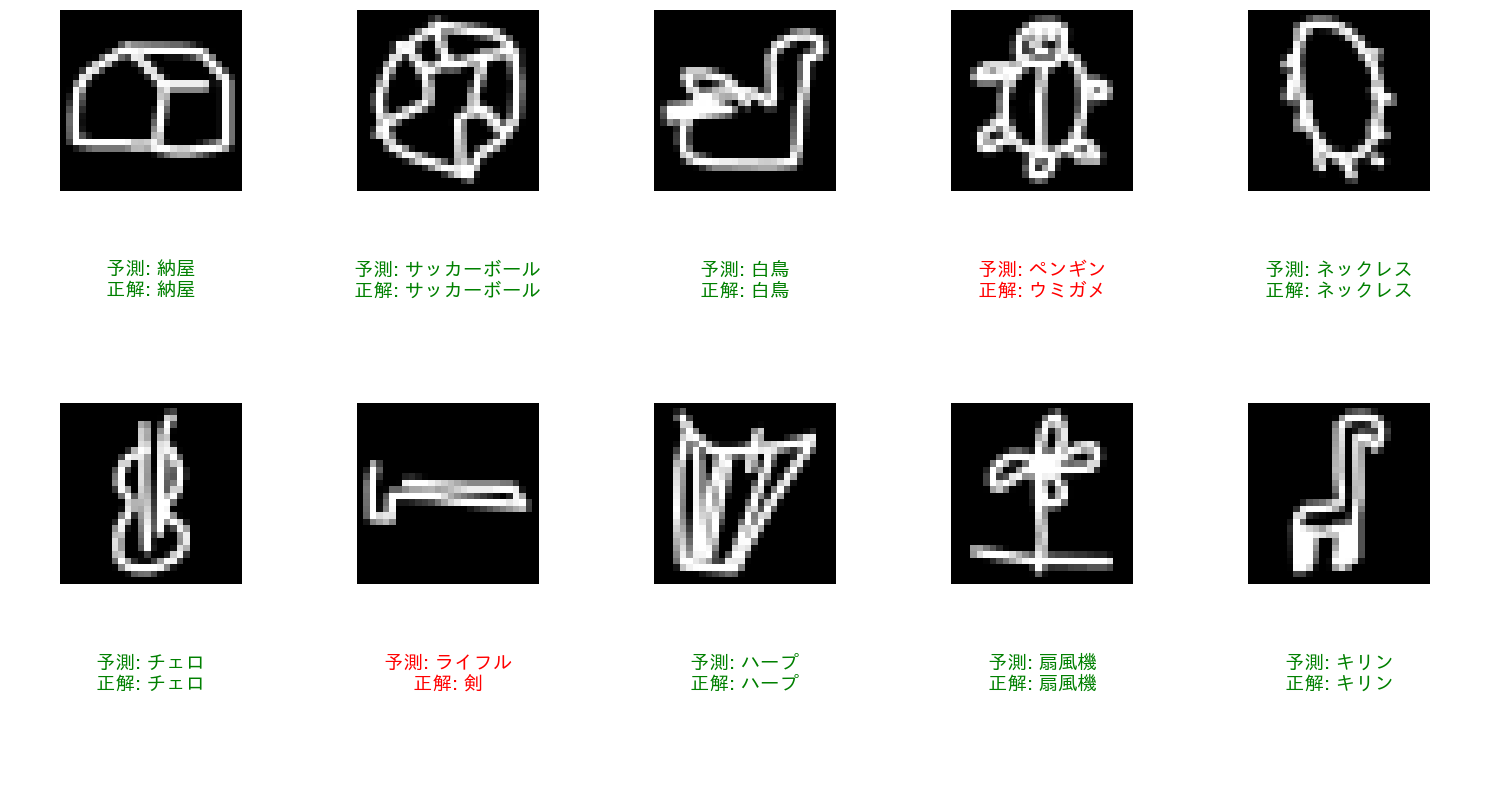

In [14]:
# 予測結果を確認
qd.predict_and_show(model)

期待した精度は出ていそうでしょうか？
何回か実行してみて、結果を確認してみてください。

<hr style="border-top: 2px solid #71EB8B;">

## 【応用】手書き絵認識ゲームの作成

最後に、Gradioを使用してインタラクティブな手描き絵認識ゲームを作成します。これにより、学習したモデルを実際に試すことができます。  
下記のコードを実行したら、`Running on public URL`の右側にあるリンクをクリックしてみてください。  
ゲームを開いて、遊んでみましょう！


In [15]:
# 必要なライブラリをインポートします
from utils import draw_game    # ユーティリティライブラリからdraw_gameをインポート
import gradio as gr            # デモアプリを作るために必要なgradioライブラリをインポート
import time                    # 時間関連の操作を行うためにtimeライブラリをインポート

# JavaScriptコードを定義します（ブラウザでのポップアップに使用）
js = "(x) => confirm(x)"

# ゲーム用に使用するクラスを定義します
game = draw_game.DrawGame(model)

# Gradioアプリケーションの構築を開始します
with gr.Blocks(theme=gr.themes.Soft()) as app:
    # ゲームのタイトルと説明を表示します
    gr.Markdown("<div style='text-align: center;'><h1>手描き絵認識ゲーム</h1><h3>3分間に指示された絵を書いて高スコアを狙おう</h3></div>")
    
    # 画面のレイアウトを設定します
    with gr.Row():
        # 画面の左側のレイアウトを設定します
        with gr.Column(scale=5):
            # ユーザー名を入力するためのテキストボックスを作成します
            user_name = gr.Textbox(label="ユーザー名")
            # ゲーム開始とリセットのためのボタンを配置します
            with gr.Row():
                start_button = gr.Button("ゲーム開始", variant="primary")
                reset_button = gr.Button("リセット")
            # ゲームの説明や指示を表示するためのテキストボックスを配置します
            output1 = gr.Textbox(value="「ユーザー名」に名前を入力して「ゲーム開始」ボタンを押してください。", label="説明", interactive=False)
            # ユーザーが数字を描くためのキャンバスを配置します
            image_input = gr.Image(
                label="スケッチ",
                source="canvas",
                shape=(200, 200),
                image_mode='L',
                tool='color-sketch',
                invert_colors=True
            ).style(width=800, height=400)
            # 判定とクリアのためのボタンを配置します
            with gr.Row():
                submit_button = gr.Button("判定", variant="primary")
                clear_button = gr.Button("クリア")
            # 判定結果を表示するためのテキストボックスを配置します
            output2 = gr.Textbox(label="結果", interactive=False)
        # 画面の右側のレイアウトを設定します
        with gr.Column(scale=5):
            # モデルの予測結果を表示するためのラベルを配置します
            output3 = gr.Label(label='予測結果', num_top_classes=5, scale=2)
            # スコアボードとランキングを表示するためのテキストボックスを配置します
            with gr.Row():
                score_board = gr.Textbox(label="スコア", value="", lines=15, scale=1)
                total_ranking = gr.Textbox(label="ランキング", value="", lines=15, scale=2)

    # それぞれのボタンに対して、クリックされたタイミングで実行される処理を定義します
    start_button.click(fn=game.start_game, inputs=[output2, user_name, gr.State(False)], outputs=[output1, total_ranking])
    reset_button.click(fn=game.start_game, inputs=[output2, user_name, gr.State(True)], outputs=[output1, total_ranking])
    clear_button.click(fn=lambda x: None, inputs=image_input, outputs=image_input)
    submit_button.click(
        fn=game.recognize_drawing,
        inputs=[output1, output2, image_input],
        outputs=[output1, output2, output3, image_input, score_board]
    )
    # 「説明」のテキストボックスと「結果」のテキストボックスに文字が入力された場合に、実行される処理を定義します
    output1.change(
        fn=None, inputs=output1, outputs=None, _js=js
    )
    output2.change(
        fn=game.start_game, inputs=output2, outputs=[output1, total_ranking], _js=js if time.time() > game.end_time else None
    )

# Gradioアプリケーションを起動します
app.queue().launch(share=True, debug=True, server_port=7865)

NoCredentialsError: Unable to locate credentials